In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os

warnings.filterwarnings("ignore")

In [83]:
# 1. Cargar datos
df_2022 = pd.read_csv('2022_limpio.csv', sep=';', parse_dates=['fecha_de_factura'], dayfirst=True)
df_2023 = pd.read_csv('2023_limpio.csv', sep=';', parse_dates=['fecha_de_factura'], dayfirst=True)
df = pd.concat([df_2022, df_2023], ignore_index=True)

In [84]:
# 2. Limpieza básica
df['cantidad_neta'] = pd.to_numeric(df['cantidad_neta'], errors='coerce')
df = df.dropna(subset=['cantidad_neta'])
df = df[df['cantidad_neta'] >= 0]  # Descartar valores negativos si no son devoluciones

In [85]:
# 3. Agrupar ventas diarias por cliente y ciudad
ventas_diarias = df.groupby(['fecha_de_factura', 'solicitante', 'CIUDAD'])['cantidad_neta'].sum().reset_index()
ventas_diarias.columns = ['fecha', 'solicitante', 'CIUDAD', 'cantidad_neta']

In [86]:
# 4. Filtrar combinaciones con al menos 180 días
clientes_unicos = ventas_diarias.groupby(['solicitante', 'CIUDAD']).size().reset_index(name='n_dias')
clientes_filtrables = clientes_unicos[clientes_unicos['n_dias'] >= 180]

In [87]:
# 5. Fecha de corte para train/test
fecha_corte = pd.to_datetime("2023-07-01")

In [88]:
# 6. Resultados finales
resultados = []

In [89]:
# 7. Función para crear características lagged
def create_features(data, target='cantidad_neta', lags=7):
    df = data[[target]].copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target].shift(lag)
    df['rolling_mean_7'] = df[target].rolling(window=7).mean()
    df['rolling_mean_30'] = df[target].rolling(window=30).mean()
    df['trend'] = np.arange(len(df))
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    df = df.dropna()
    return df

In [90]:
# Festivos Colombia
co_holidays = holidays.Colombia(years=[2022, 2023])

# Añadir festivos y días especiales
def add_special_days(X):
    X = X.copy()
    X['es_festivo'] = X.index.map(lambda x: int(x in co_holidays))
    X['es_ultimo_dia_mes'] = (X.index + pd.offsets.MonthEnd(0) == X.index).astype(int)
    X['es_primer_dia_mes'] = (X.index.day == 1).astype(int)
    X['es_viernes'] = (X.index.dayofweek == 4).astype(int)
    X['es_lunes'] = (X.index.dayofweek == 0).astype(int)
    X['es_fin_semana'] = ((X.index.dayofweek == 5) | (X.index.dayofweek == 6)).astype(int)
    return X

In [ ]:
# 8. Bucle por cada cliente + ciudad

predictions_agg = []

if not os.path.exists('plots'):
    os.makedirs('plots')

for _, row in clientes_filtrables.iterrows():
    cliente = row['solicitante']
    ciudad = row['CIUDAD']

    # Filtrar por cliente y ciudad
    subset = ventas_diarias[
        (ventas_diarias['solicitante'] == cliente) &
        (ventas_diarias['CIUDAD'] == ciudad)
    ].copy()

    # Asegurar frecuencia diaria
    subset = subset.set_index('fecha').asfreq('D')
    subset['cantidad_neta'] = subset['cantidad_neta'].fillna(0)

    if len(subset) < 180:
        continue

    try:
        # Crear características derivadas
        features_df = create_features(subset[['cantidad_neta']], lags=7)
        features_df = add_special_days(features_df)

        # Separar X e y
        X = features_df.drop(columns=['cantidad_neta'])
        y = features_df['cantidad_neta']

        # Dividir en train/test usando fechas
        idx_corte = y.index < fecha_corte
        X_train, X_test = X[idx_corte], X[~idx_corte]
        y_train, y_test = y[idx_corte], y[~idx_corte]

        # Validación de longitud mínima
        if len(X_train) < 180 or len(X_test) < 30:
            continue

        # Escalar datos
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Verificar consistencia
        assert len(X_train_scaled) == len(y_train), "X_train y y_train no coinciden"
        assert len(X_test_scaled) == len(y_test), "X_test y y_test no coinciden"

        # Entrenar modelos base
        # Medir tiempo de entrenamiento de modelos base
        start_train_base_time = time.time()
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

        rf.fit(X_train_scaled, y_train)
        xgb.fit(X_train_scaled, y_train)

        end_train_base_time = time.time()
        train_base_time_seconds = end_train_base_time - start_train_base_time

        # Predicciones
        start_inference_base_time = time.time()
        rf_pred = rf.predict(X_test_scaled)
        xgb_pred = xgb.predict(X_test_scaled)
        end_inference_base_time = time.time()
        inference_base_time_seconds = end_inference_base_time - start_infere

        # Stacking
        stacked_input_train = np.column_stack((rf.predict(X_train_scaled), xgb.predict(X_train_scaled)))
        start_train_meta_time = time.time()
        # meta_model = LinearRegression()
        meta_model = Ridge(alpha=1.0, random_state=42)
        # meta_model.fit(stacked_input, y_test)
        meta_model.fit(stacked_input_train, y_train)
        end_train_meta_time = time.time()
        train_meta_time_seconds = end_train_meta_time - start_train_meta_time

        # Stacking y medición de tiempo de inferencia del meta-modelo
        start_inference_meta_time = time.time()
        final_pred = meta_model.predict(stacked_input_train)
        end_inference_meta_time = time.time()
        inference_meta_time_seconds = end_inference_meta_time - start_inference_meta_time

        # Tiempo total de entrenamiento e inferencia para el stacked model
        total_train_time_seconds = train_base_time_seconds + train_meta_time_seconds
        total_inference_time_seconds = inference_base_time_seconds + inference_meta_time_seconds

        # Evaluación
        mae = mean_absolute_error(y_test, final_pred)
        promedio_real = y_test.mean()
        mae_relativo = mae / promedio_real if promedio_real != 0 else None

        accuracy = 1 - mae / promedio_real if promedio_real != 0 else None
        precision = 1 - mae / y_test.mean() if y_test.mean() != 0 else None
        recall = 1 - mae / y_test.mean() if y_test.mean() != 0 else None
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision is not None and recall is not None) else None
        

        mask = y_test != 0
        if mask.any():
            mape = mean_absolute_percentage_error(y_test[mask], final_pred[mask]) * 100
        else:
            mape = None

        resultados.append({
            'cliente': cliente,
            'ciudad': ciudad,
            'MAE': mae,
            'Promedio_ventas_test': promedio_real,
            'MAE_relativo': mae_relativo,
            'MAPE (%)': mape,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'observaciones': len(features_df),
            'tiempo_entrenamiento_segundos': total_train_time_seconds,
            'tiempo_inferencia_segundos': total_inference_time_seconds
        })

        data_plot = pd.DataFrame({
            'fecha': y_test.index,
            'real': y_test.values,
            'pred': final_pred
        })
        data_plot['ciudad'] = ciudad
        # data_plot['cliente'] = cliente # se omite cliente para no generar tantas gráficas
        predictions_agg.append(data_plot)

        # Graficar Serie temporal: Ventas reales vs. Predicción (se guardan en carpeta plots)
        plt.figure(figsize=(12, 6))
        plt.plot(y_test.index, y_test, label='Ventas Reales')
        plt.plot(y_test.index, final_pred, label='Predicción', linestyle='--')
        plt.title(f'Ventas Reales vs. Predicción - Cliente: {cliente} | Ciudad: {ciudad}')
        plt.xlabel('Fecha')
        plt.ylabel('Cantidad Neta')
        plt.legend()
        plt.savefig(f'plots/{ciudad}_cliente_{cliente}_real_vs_pred.png', bbox_inches='tight')
        plt.close()

        # Graficar Scatter plot: Predicción vs. Ventas reales (se guardan en carpeta plots)
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, final_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.title(f'Scatter: Predicción vs. Ventas reales - Cliente: {cliente} | Ciudad: {ciudad}')
        plt.xlabel('Ventas Reales')
        plt.ylabel('Predicción')
        plt.savefig(f'plots/{ciudad}_cliente_{cliente}_scatter.png', bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Error en {cliente} - {ciudad}: {e}")
        continue

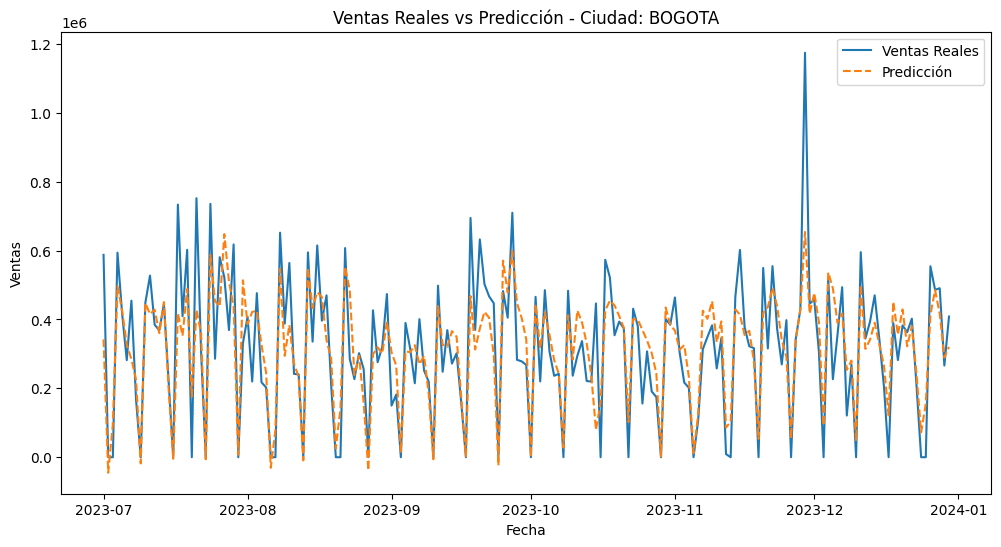

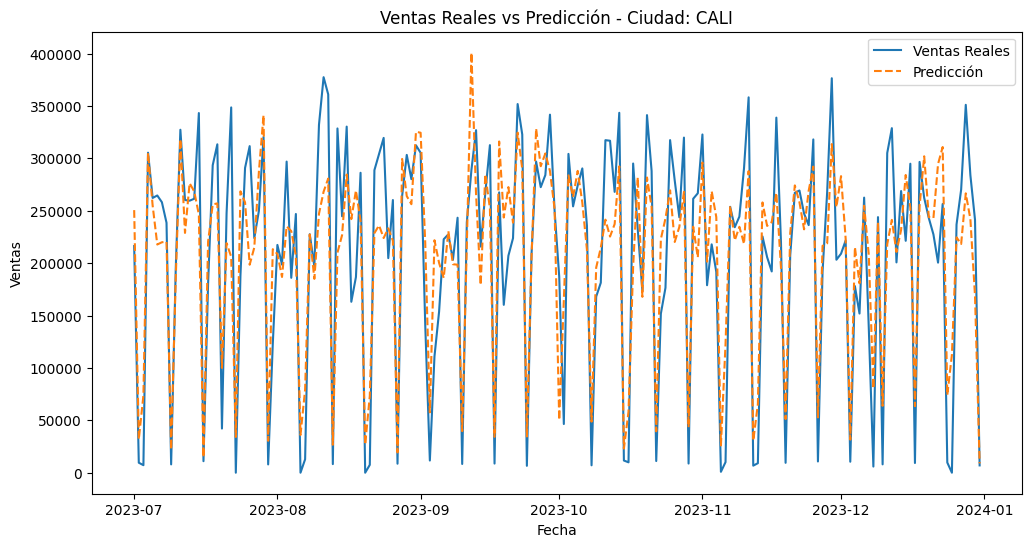

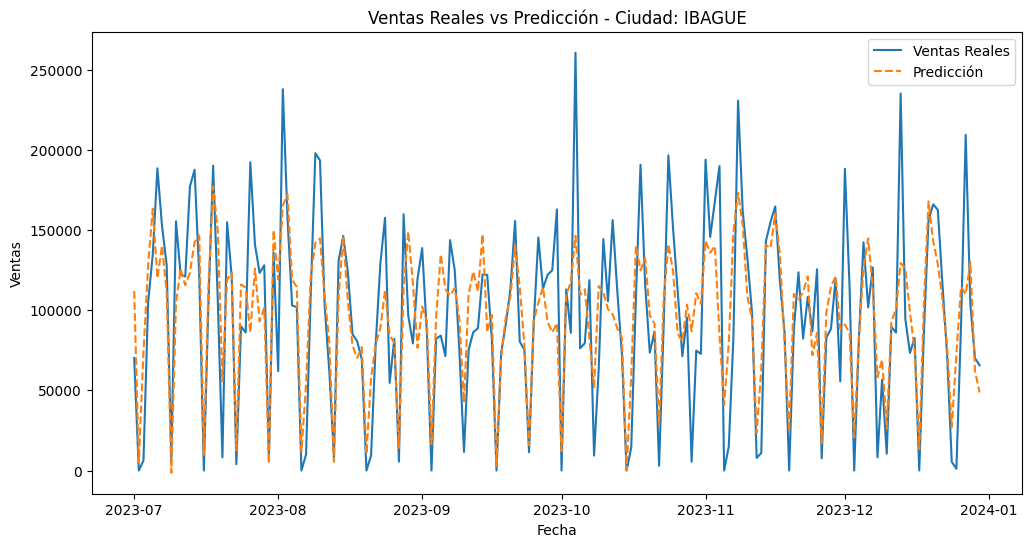

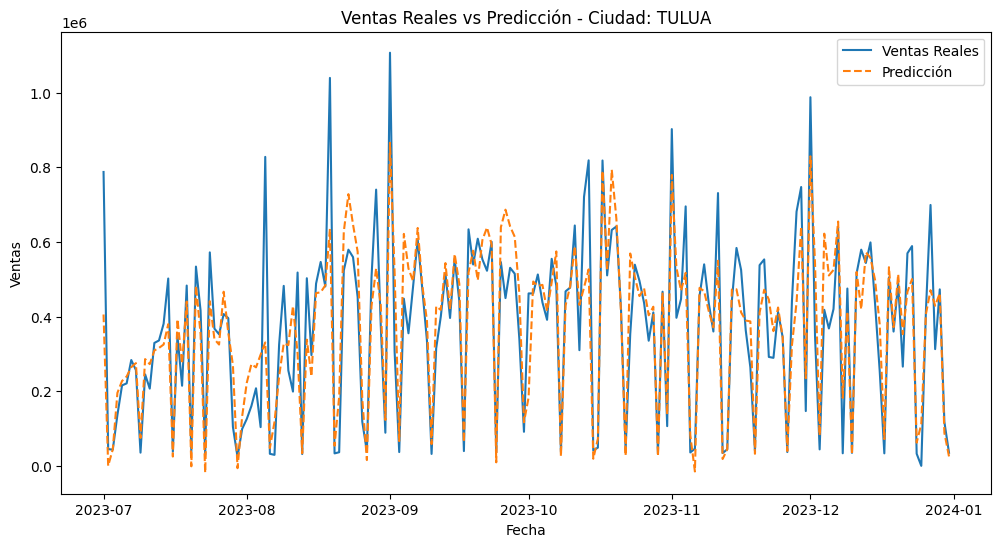

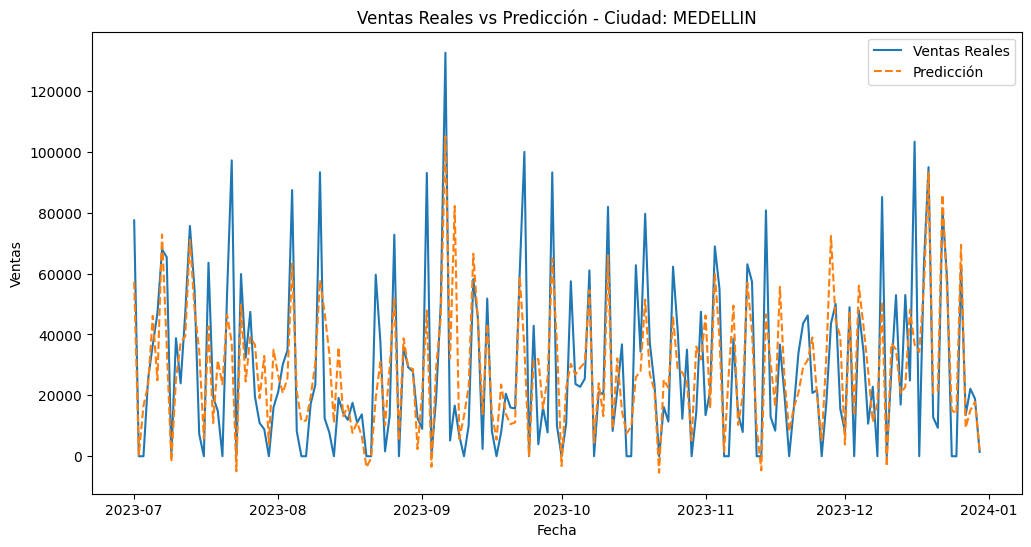

In [ ]:
df_predictions = pd.concat(predictions_agg, ignore_index=True)

# 9. Gráfica por cada ciudad
ciudades = df_predictions['ciudad'].unique()
for city in ciudades:
    group = df_predictions[df_predictions['ciudad'] == city].groupby('fecha').agg({'real': 'sum', 'pred': 'sum'}).reset_index()
    plt.figure(figsize=(12,6))
    plt.plot(group['fecha'], group['real'], label='Ventas Reales')
    plt.plot(group['fecha'], group['pred'], label='Predicción', linestyle='--')
    plt.title(f'Ventas Reales vs Predicción - Ciudad: {city}')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.show()

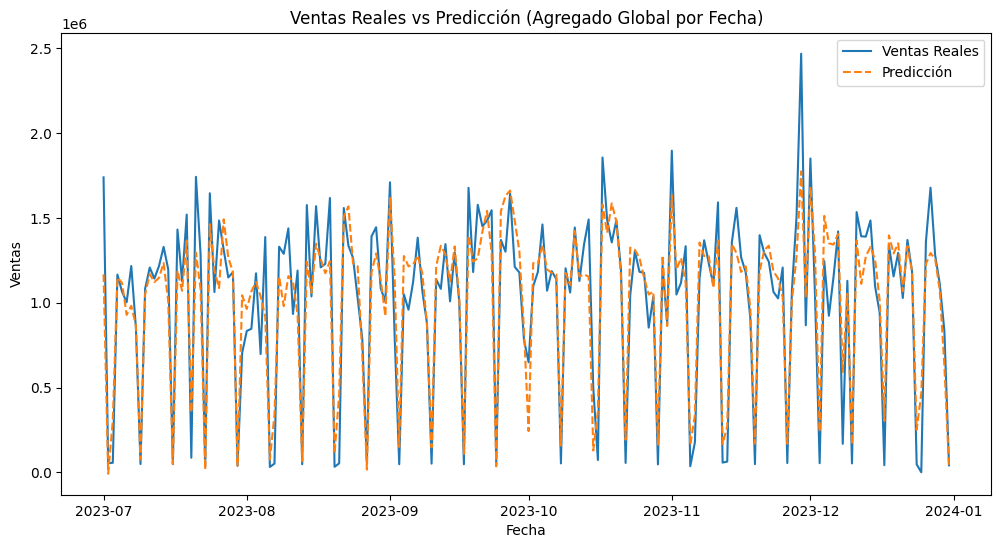

In [ ]:
# 10. Grafica Ventas Reales vs Predicción (Agregado Global por Fecha)
df_total = df_predictions.groupby('fecha').agg({'real': 'sum', 'pred': 'sum'}).reset_index()

plt.figure(figsize=(12,6))
plt.plot(df_total['fecha'], df_total['real'], label='Ventas Reales')
plt.plot(df_total['fecha'], df_total['pred'], label='Predicción', linestyle='--')
plt.title('Ventas Reales vs Predicción (Agregado Global por Fecha)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

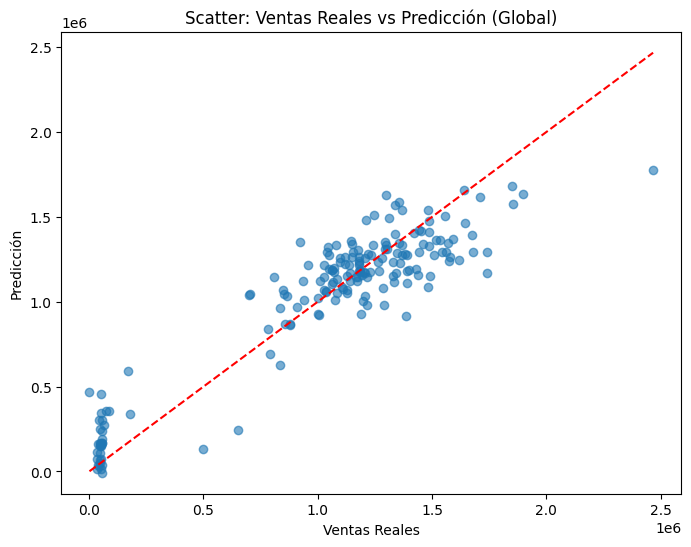

In [ ]:
# 11. Grafica Scatter: Ventas Reales vs Predicción (Global)
plt.figure(figsize=(8,6))
plt.scatter(df_total['real'], df_total['pred'], alpha=0.6)
plt.plot([df_total['real'].min(), df_total['real'].max()],
         [df_total['real'].min(), df_total['real'].max()],
         'r--')
plt.title('Scatter: Ventas Reales vs Predicción (Global)')
plt.xlabel('Ventas Reales')
plt.ylabel('Predicción')
plt.show()

In [ ]:
# 12. Mostrar resultados
df_resultados = pd.DataFrame(resultados).sort_values('MAE')
df_resultados

,cliente,ciudad,MAE,Promedio_ventas_test,MAE_relativo,MAPE (%),accuracy,precision,recall,f1_score,observaciones
644,1032353.0,BOGOTA,1.426139,1.099291,1.297326,51.443818,-0.297326,-0.297326,-0.297326,-0.297326,551
42,1001221.0,TULUA,4.401573,42.388889,0.103838,8.905464,0.896162,0.896162,0.896162,0.896162,693
616,1031680.0,IBAGUE,7.125718,11.933702,0.597109,23.851831,0.402891,0.402891,0.402891,0.402891,693
670,18000293.0,BOGOTA,7.339196,6.000000,1.223199,79.009536,-0.223199,-0.223199,-0.223199,-0.223199,549
640,1032204.0,IBAGUE,9.207870,21.546961,0.427340,27.837892,0.572660,0.572660,0.572660,0.572660,639
...,...,...,...,...,...,...,...,...,...,...,...
550,1030131.0,IBAGUE,22105.786480,30339.767956,0.728608,351.983723,0.271392,0.271392,0.271392,0.271392,695
119,1004155.0,CALI,23655.336582,49272.890110,0.480088,79.870369,0.519912,0.519912,0.519912,0.519912,698
34,1000936.0,BOGOTA,34702.772570,75595.092896,0.459061,104.018376,0.540939,0.540939,0.540939,0.540939,698
247,1018222.0,BOGOTA,58335.365324,96237.573770,0.606160,46.725244,0.393840,0.393840,0.393840,0.393840,698


In [ ]:
# 13. Clasificación por MAPE
def clasificar_mape(mape):
    if pd.isna(mape):
        return 'Sin datos'
    elif mape < 10:
        return 'Excelente'
    elif mape < 20:
        return 'Buena'
    elif mape < 50:
        return 'Aceptable'
    else:
        return 'Mala'

df_resultados['desempeño'] = df_resultados['MAPE (%)'].apply(clasificar_mape)

In [97]:
print("\nDistribución del desempeño (porcentaje):")
print(df_resultados['desempeño'].value_counts(normalize=True) * 100)
print(df_resultados['MAPE (%)'].mean())


Distribución del desempeño (porcentaje):
desempeño
Aceptable    68.852459
Mala         27.421759
Buena         3.278689
Excelente     0.447094
Name: proportion, dtype: float64
52.28947300801853


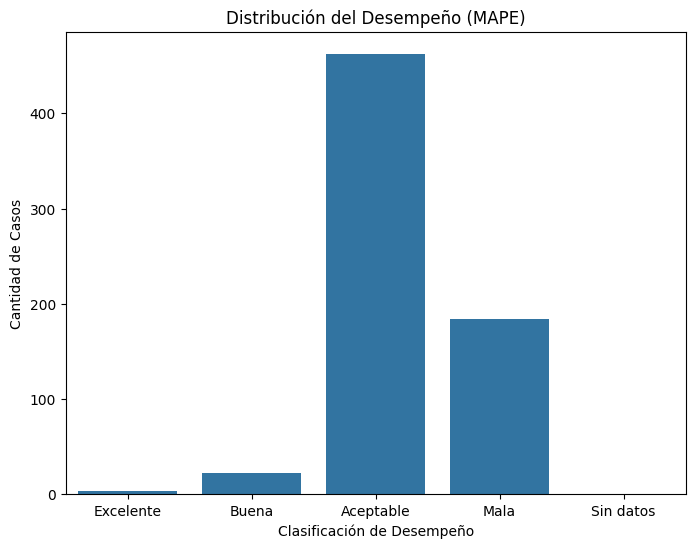

In [ ]:
# 14. Distribución del desempeño (por MAPE)
plt.figure(figsize=(8, 6))
sns.countplot(x='desempeño', data=df_resultados, order=['Excelente', 'Buena', 'Aceptable', 'Mala', 'Sin datos'])
plt.title('Distribución del Desempeño (MAPE)')
plt.xlabel('Clasificación de Desempeño')
plt.ylabel('Cantidad de Casos')
plt.show()

In [ ]:
# 15. Clasificación por accuracy
def clasificar_accuracy(accuracy):
    if pd.isna(accuracy):
        return 'Sin datos'
    elif accuracy > 0.9:
        return 'Excelente'
    elif accuracy > 0.75:
        return 'Buena'
    elif accuracy > 0.6:
        return 'Aceptable'
    else:
        return 'Mala'

df_resultados['desempeño_accuracy'] = df_resultados['accuracy'].apply(clasificar_accuracy)

In [100]:
print("\nDistribución del desempeño de accuracy (porcentaje):")
print(df_resultados['desempeño_accuracy'].value_counts(normalize=True) * 100)
print(df_resultados['accuracy'].mean())


Distribución del desempeño de accuracy (porcentaje):
desempeño_accuracy
Mala         88.077496
Aceptable     9.538003
Buena         2.235469
Excelente     0.149031
Name: proportion, dtype: float64
0.26608118095057637


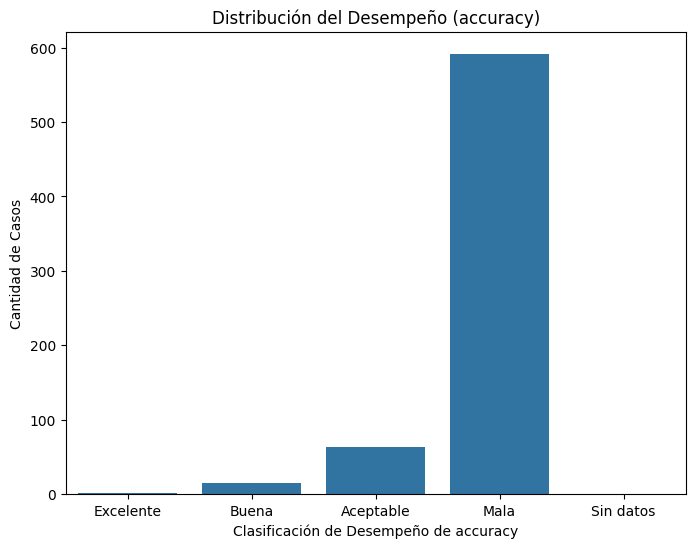

In [ ]:
# 16. Distribución del desempeño (por accuracy)
plt.figure(figsize=(8, 6))
sns.countplot(x='desempeño_accuracy', data=df_resultados, order=['Excelente', 'Buena', 'Aceptable', 'Mala', 'Sin datos'])
plt.title('Distribución del Desempeño (accuracy)')
plt.xlabel('Clasificación de Desempeño de accuracy')
plt.ylabel('Cantidad de Casos')
plt.show()

In [ ]:
# Análisis de Complejidad (Tiempos de Entrenamiento e Inferencia)

print("\n--- Resumen de Tiempos de Complejidad ---")

# Filtrar solo casos donde se pudo calcular el tiempo (evitar errores None o NaN)
df_tiempos = df_resultados.dropna(subset=['tiempo_entrenamiento_segundos', 'tiempo_inferencia_segundos'])

if not df_tiempos.empty:
    # Estadísticas para el tiempo de entrenamiento
    total_train_time = df_tiempos['tiempo_entrenamiento_segundos'].sum()
    avg_train_time = df_tiempos['tiempo_entrenamiento_segundos'].mean()
    median_train_time = df_tiempos['tiempo_entrenamiento_segundos'].median()
    max_train_time = df_tiempos['tiempo_entrenamiento_segundos'].max()
    min_train_time = df_tiempos['tiempo_entrenamiento_segundos'].min()

    print(f"\n**Tiempos de Entrenamiento (en segundos) para {len(df_tiempos)} modelos:**")
    print(f"  Tiempo Total: {total_train_time:.2f} segundos ({total_train_time / 60:.2f} minutos)")
    print(f"  Promedio por modelo: {avg_train_time:.4f} segundos")
    print(f"  Mediana por modelo: {median_train_time:.4f} segundos")
    print(f"  Máximo por modelo: {max_train_time:.4f} segundos")
    print(f"  Mínimo por modelo: {min_train_time:.4f} segundos")

    # Estadísticas para el tiempo de inferencia
    total_inference_time = df_tiempos['tiempo_inferencia_segundos'].sum()
    avg_inference_time = df_tiempos['tiempo_inferencia_segundos'].mean()
    median_inference_time = df_tiempos['tiempo_inferencia_segundos'].median()
    max_inference_time = df_tiempos['tiempo_inferencia_segundos'].max()
    min_inference_time = df_tiempos['tiempo_inferencia_segundos'].min()

    print(f"\n**Tiempos de Inferencia (en segundos) para {len(df_tiempos)} modelos:**")
    print(f"  Tiempo Total: {total_inference_time:.2f} segundos ({total_inference_time / 60:.2f} minutos)")
    print(f"  Promedio por modelo: {avg_inference_time:.4f} segundos")
    print(f"  Mediana por modelo: {median_inference_time:.4f} segundos")
    print(f"  Máximo por modelo: {max_inference_time:.4f} segundos")
    print(f"  Mínimo por modelo: {min_inference_time:.4f} segundos")

    # Visualización de la distribución de tiempos
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df_tiempos['tiempo_entrenamiento_segundos'], bins=30, kde=True)
    plt.title('Distribución del Tiempo de Entrenamiento por Modelo')
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Frecuencia')

    plt.subplot(1, 2, 2)
    sns.histplot(df_tiempos['tiempo_inferencia_segundos'], bins=30, kde=True)
    plt.title('Distribución del Tiempo de Inferencia por Modelo')
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

else:
    print("No hay datos de tiempo disponibles para analizar.")

In [102]:
# Guardar resultados en Excel
df_resultados.to_excel('resultados_modelo_stacked_random_forest_xgboost.xlsx', index=False)